In [7]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import matplotlib.animation as animation
from IPython.display import HTML
plt.rcParams['figure.dpi'] = 300  
plt.rcParams['animation.embed_limit'] = 30

Text(0.5, 1.0, 'Lennard-Jones potential')

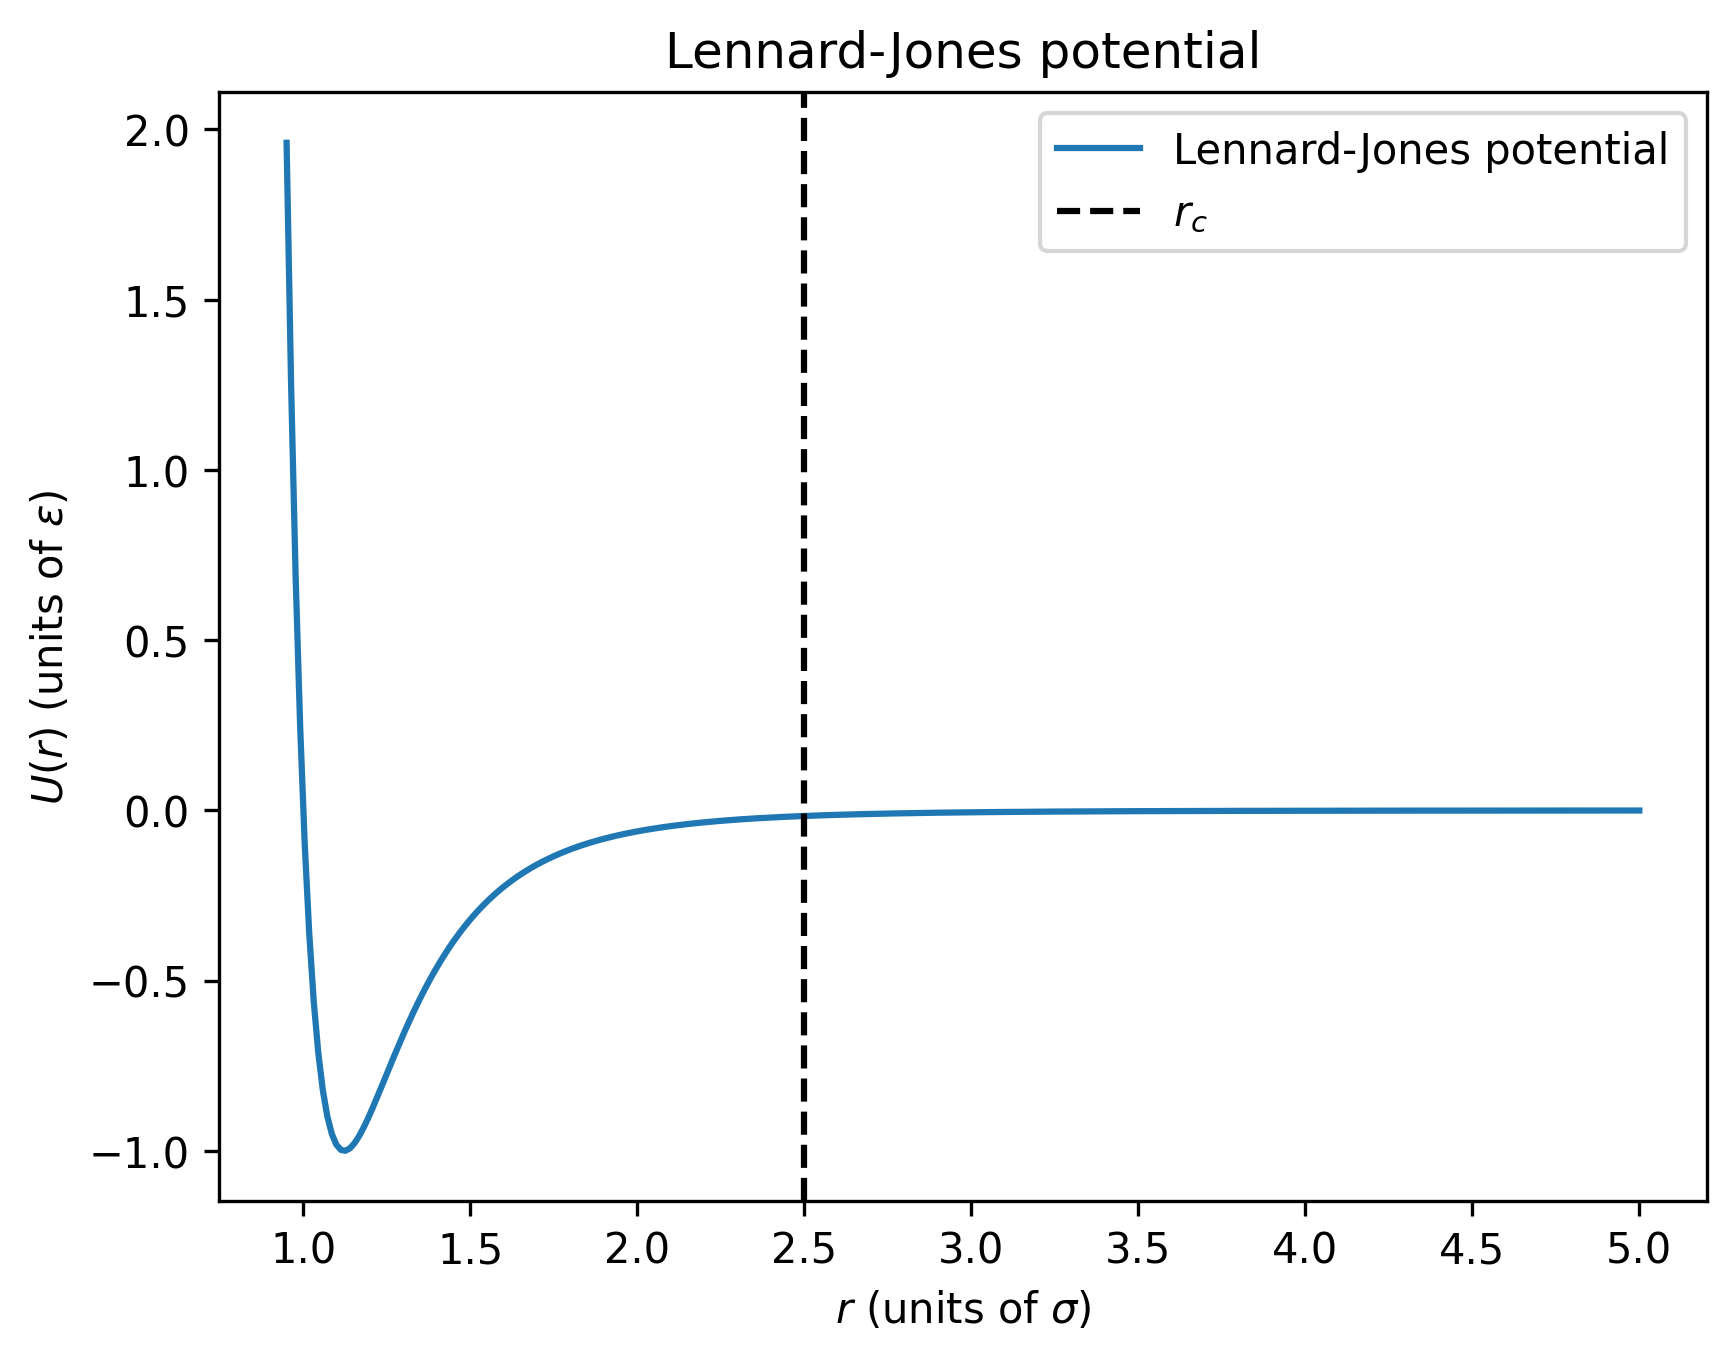

In [8]:
rc = 2.5 #cutoff distance

ULJ = lambda r: 4*(1/r**12 - 1/r**6) # Lennard-Jones potential


#plot the potential energy vs the distance, include a vertical line at the cutoff distance
r = np.linspace(0.95, 5, 300)

plt.plot(r, ULJ(r), label='Lennard-Jones potential')
plt.xlabel('$r$ (units of $\sigma$)',)
plt.ylabel('$U(r)$ (units of $\epsilon$)')
plt.axvline(rc, color='k', linestyle='--', label='$r_c$')
plt.legend()
plt.title('Lennard-Jones potential')

1/r^12 captures repulsive, 1/r^6 is attraction. Further away, the lj potential disapates

In [9]:
#simulation variables
N = 100 # number of particles
radius = 0.3 # radius of particles
L = 10 # length of box
duration = 10  # duration of simulation
nsteps = 1500 # number of steps
dt = duration/nsteps  # time step
v0 = 1.5 # initial velocity magnitude


#initialize the postions of the particles in a grid
grid_size = int(np.ceil(np.sqrt(N))) # Create enough positions in grid for the particles
spacing = L/ grid_size 
x = np.linspace(radius + spacing/2, L - radius - spacing/2, grid_size) 
pos = list(product(x, x))
positions = np.array(pos[:N]) 

#initialize the velocities: random directions but fixed magnitude
theta = np.random.uniform(0, 2*np.pi, size=N)
vx,vy = v0*np.cos(theta), v0*np.sin(theta)
velocities = np.stack((vx,vy), axis=1)

(0.0, 10.0)

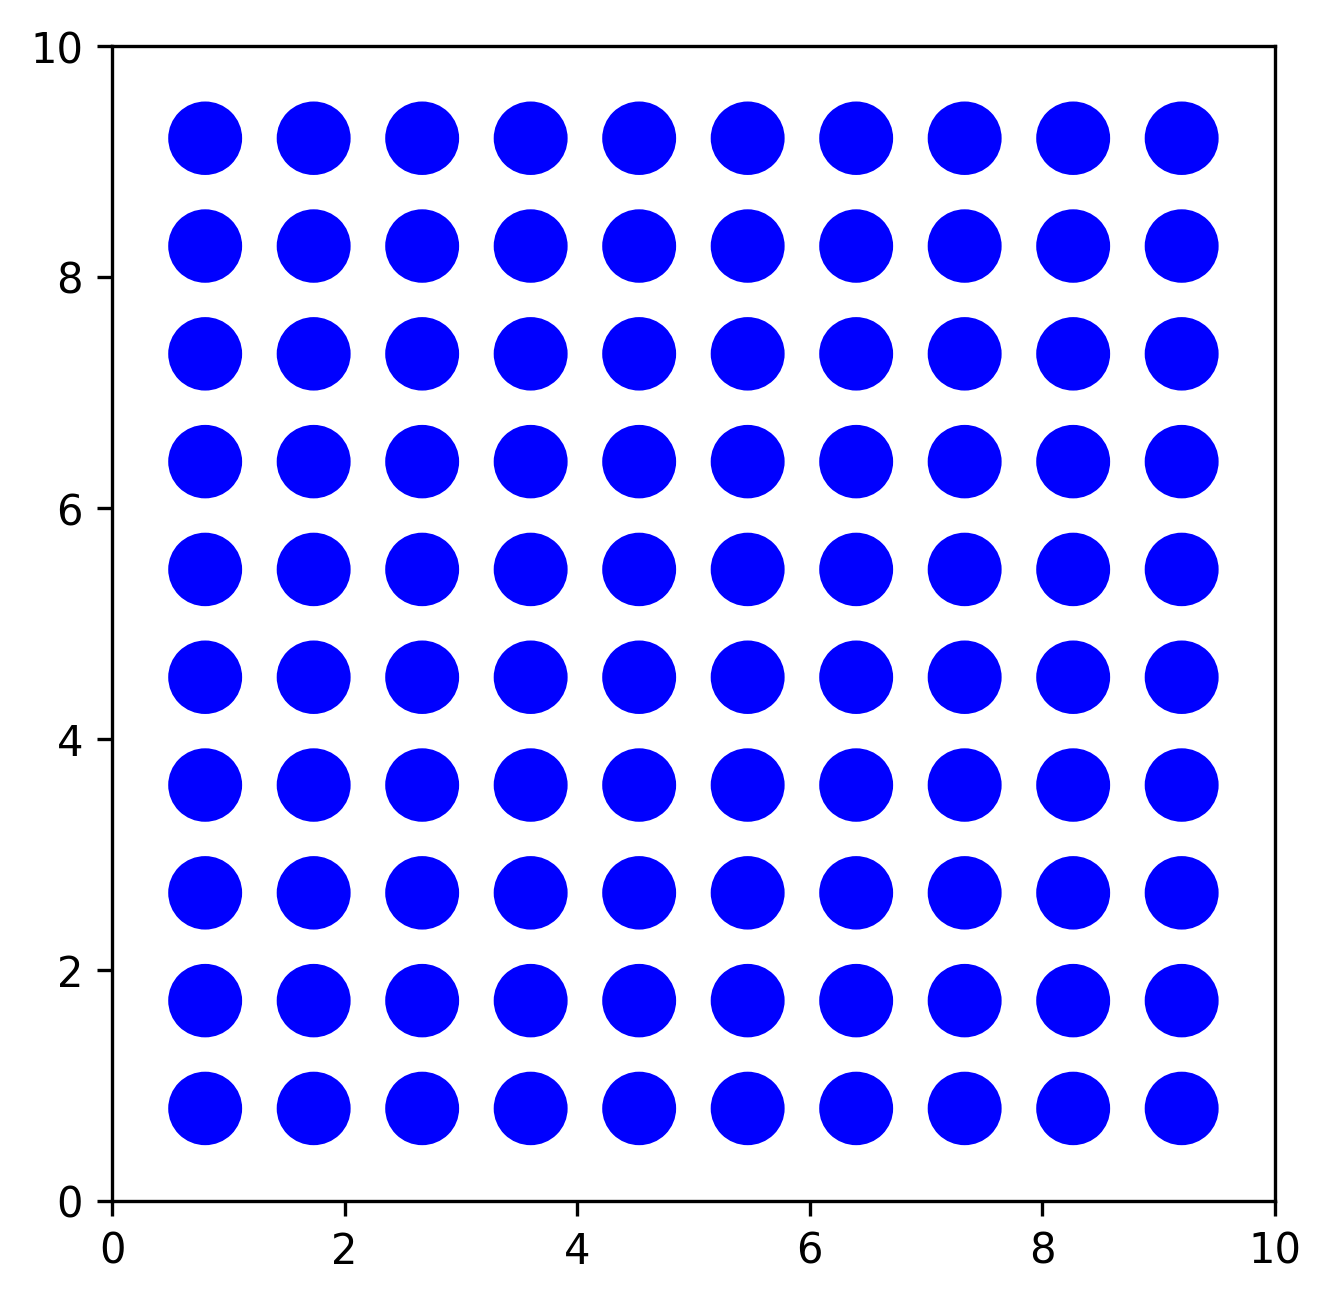

In [10]:
fig,ax = plt.subplots(figsize=(5,5))
for i in range(N):
    circle = plt.Circle((positions[i,0], positions[i,1]),radius, fill=True, color='blue') #plot the particle
    ax.add_artist(circle)

ax.set_xlim(0,L)
ax.set_ylim(0,L)

Text(0, 0.5, '$y$ (units of $\\sigma$)')

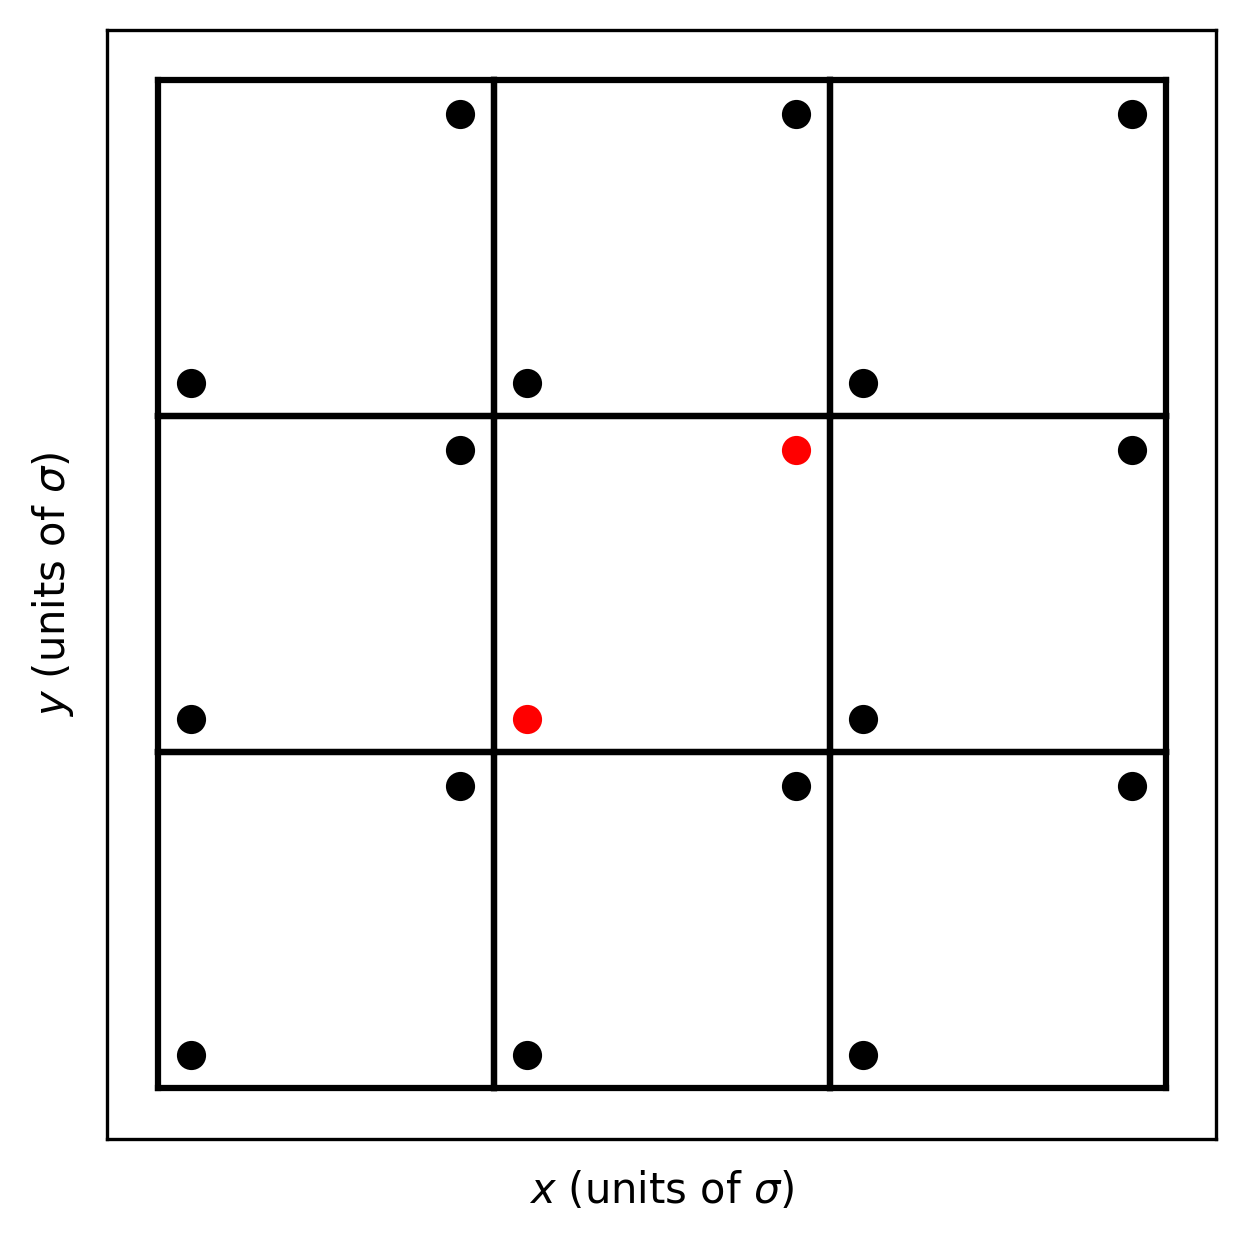

In [11]:
r1, r2 = np.array([0.9*L, 0.9*L]), np.array([0.1*L, 0.1*L]) #initialize two particles

for i in range(-1,2):
    for j in range(-1,2):
        if i == 0 and j == 0:
            plt.plot(r1[0]+i*L, r1[1]+j*L, 'ro')  # Plot in red
            plt.plot(r2[0]+i*L, r2[1]+j*L, 'ro')  # Plot in blue
        else:
            plt.plot(r1[0]+i*L, r1[1]+j*L, 'ko')  # Plot in black
            plt.plot(r2[0]+i*L, r2[1]+j*L, 'ko')  # Plot in black

        plt.plot([i*L, (i+1)*L], [j*L, j*L], 'k-')  # Horizontal side
        plt.plot([i*L, i*L], [j*L, (j+1)*L], 'k-')  # Vertical side
        plt.plot([(i+1)*L, (i+1)*L], [j*L, (j+1)*L], 'k-')  # Vertical side
        plt.plot([i*L, (i+1)*L], [(j+1)*L, (j+1)*L], 'k-')  # Horizontal side

plt.xticks([]) # Remove x-ticks
plt.yticks([]) # Remove y-ticks

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('$x$ (units of $\sigma$)')
plt.ylabel('$y$ (units of $\sigma$)')

In [12]:
def pair_vector(r1,r2,L):
    """Calculate the vector r2 - r1 with periodic boundary conditions."""
    r = r2 - r1
    r -= np.rint(r / L) * L
    return r

In [13]:
def force(r1,r2,L):
    """Calculate the force on particle 1 due to particle 2."""
    r = pair_vector(r1,r2,L) #calculate the vector between the particles
    r_mag = np.linalg.norm(r) #calculate the magnitude of the vector
    
    if r_mag < rc:
        return (-48/r_mag**14 + 24/r_mag**8) * r # force
    else:
        return np.zeros(2) # too far apart, 0

In [14]:
def get_forces(positions,L):
    """Calculate the forces on all particles."""
    forces = np.zeros_like(positions) # N particles
    N = positions.shape[0]
    for i in range(N):
        for j in range(i+1,N):
            r1,r2 = positions[i],positions[j]
            forces[i] += force(r1,r2,L)
            forces[j] -= force(r1,r2,L)
    return forces

# what is the net force felt by all particles
# take position, store forces of each particle 

In [15]:
def step(positions, velocities, L,dt): 
    
    forces = get_forces(positions, L)
    positions[:] = positions + velocities*dt + 0.5*forces*dt**2
    next_forces = get_forces(positions, L)
    velocities[:] = velocities + 0.5*(forces + next_forces)*dt
    return positions, velocities


In [16]:
def animate(positions, velocities, L, nsteps):


    all_positions = np.zeros((nsteps, N, 2)) #store all positions
    all_velocities = np.zeros_like(all_positions) #store all velocities

    for t in range(nsteps): #iterate over all steps
        all_positions[t] = positions #add to positions positions
        all_velocities[t] = velocities #add to velocities velocities
        positions, velocities = step(positions, velocities, L,dt) #step forward in time


    return all_positions, all_velocities



all_positions, all_velocities = animate(positions, velocities, L, nsteps)



C:\Users\Justin\AppData\Local\Temp\ipykernel_13824\3752183888.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return (-48/r_mag**14 + 24/r_mag**8) * r # force
C:\Users\Justin\AppData\Local\Temp\ipykernel_13824\3752183888.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (-48/r_mag**14 + 24/r_mag**8) * r # force


In [17]:
#compute the total potential energy at each step
potential_energy = np.zeros(nsteps)
for i in range(nsteps):
    for j in range(N):
        for k in range(j+1,N):
            r = pair_vector(all_positions[i,j],all_positions[i,k],L)
            r_mag = np.linalg.norm(r)
            if r_mag < rc:
                potential_energy[i] += ULJ(r_mag)


#compute the total kinetic energy at each step
kinetic_energy = 0.5 * np.sum(np.linalg.norm(all_velocities, axis=2)**2,axis=1)


C:\Users\Justin\AppData\Local\Temp\ipykernel_13824\2625038212.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  ULJ = lambda r: 4*(1/r**12 - 1/r**6) # Lennard-Jones potential
C:\Users\Justin\AppData\Local\Temp\ipykernel_13824\2625038212.py:3: RuntimeWarning: invalid value encountered in double_scalars
  ULJ = lambda r: 4*(1/r**12 - 1/r**6) # Lennard-Jones potential


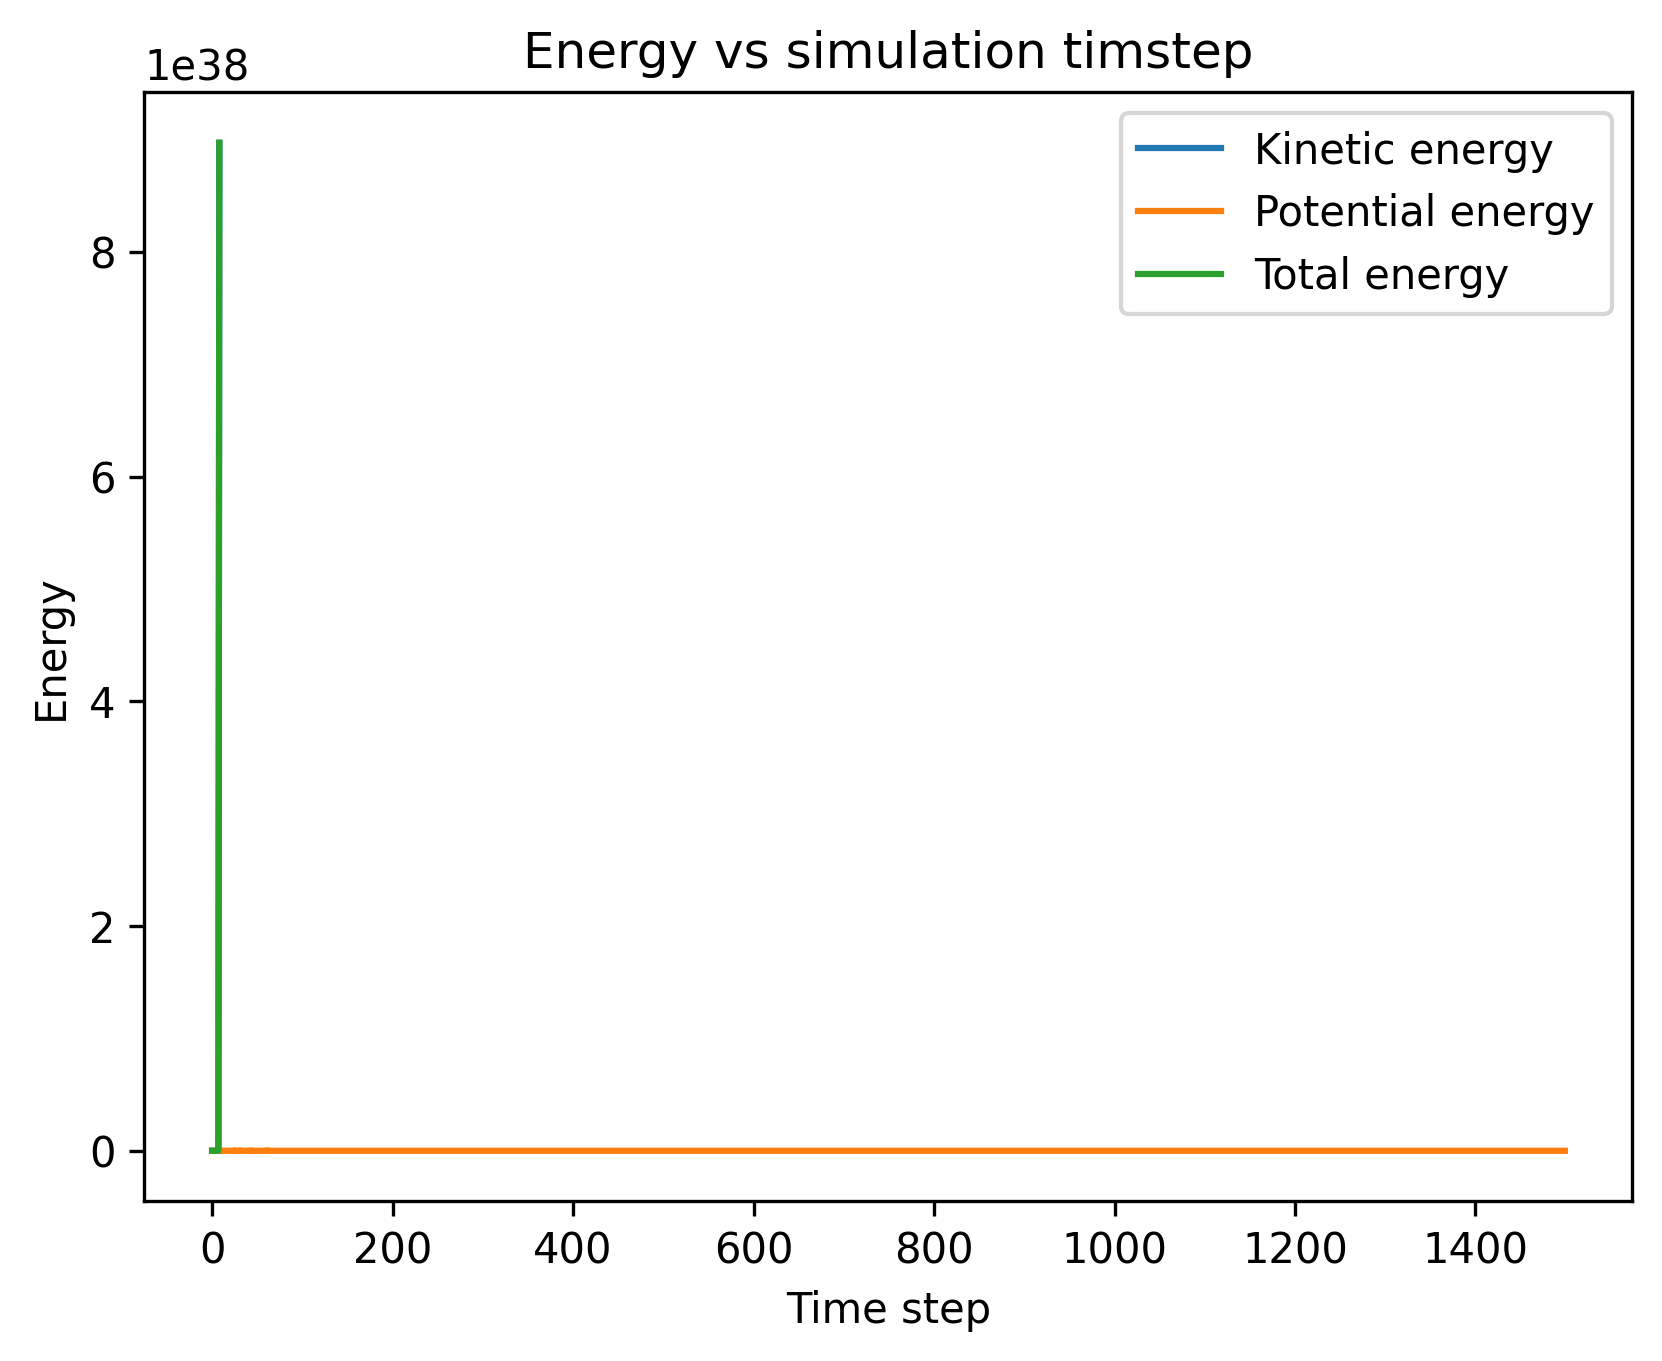

In [18]:
plt.plot(np.arange(nsteps), kinetic_energy, label = 'Kinetic energy')
plt.plot(np.arange(nsteps), potential_energy, label = 'Potential energy')
plt.plot(np.arange(nsteps), kinetic_energy + potential_energy, label = 'Total energy')
plt.xlabel('Time step')
plt.ylabel('Energy')
plt.title('Energy vs simulation timstep')
plt.legend()